In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib import patches
from random import shuffle, randint

import selectivesearch
import skimage.data

import matplotlib.patches as mpatches
import time

In [2]:
import ipython_import

In [3]:
from roi_pooling_importer import import_roi_pooling_op
import VOC_import

importing IPython notebook from roi_pooling_importer.ipynb
importing IPython notebook from VOC_import.ipynb


In [4]:
roi_pooling_op_dir = os.getenv("HOME") + "/packages/tensorflow/bazel-bin/tensorflow/core/user_ops/"
roi_pooling_op = import_roi_pooling_op(roi_pooling_op_dir)

In [5]:
# This will be trained with BGR images with pixels in range [-255, 255]
# Takes a list of ROIs. Currently only handles one image at a time. 
# ROIs must be scaled with roi_scaling factor before input

# The width and height of the image
image_size = 224 # Must be divisible by the pooling layers

# Image depth
image_depth = 3

# The batch size
batch_size = 1

# number of classes
num_classes = 20
num_classes_with_background = num_classes + 1

# The number of region proposals
#num_rois = 200

# The scaling factor for ROIs - equivalent to the combined downsampling of all prior strided accesses
# 4 (conv1) * 2 (pool1) * 2 (pool2) = 16
roi_scaling = 16

# Pixel means (probably for PASCAL VOC?) in BGR order
pixel_means = np.array([[[102.9801, 115.9465, 122.7717]]])

# Device to use
device = "gpu"

In [6]:
# TODO: background examples
# TODO: fix data ordering to NCHW
# TODO look at graph output in visualizer to make sure it looks right
# TODO fix the default initializations of weights and biases if we want to train
# TODO add dropout
# TODO add weight decay

In [7]:
# Parameters to think about tweaking:
# LRU: k, alpha, beta
# Inputs: input image normalization, background examples, etc
# Data ordering: NCHW vs NHWC
# Outputs: add bounding box regression
# Weights: initial values
# Dropout, weight decay

In [8]:
# Helper functions for defining networks
def weight_variable(shape, wd):
    initial = tf.truncated_normal(shape, stddev=0.01)
    weight_decay = tf.mul(tf.nn.l2_loss(initial), wd)
    tf.add_to_collection('losses', weight_decay)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool(x, kernel_size, stride):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1],
                        strides=[1, stride, stride, 1], padding='SAME')

def local_response_normalization(x):
    # TODO is 5 the correct radius?
    return tf.nn.local_response_normalization(x, depth_radius=5, alpha=.0001, beta=.75, bias=2)

In [9]:
# Something like Alexnet
sess = tf.InteractiveSession(config=tf.ConfigProto(
    allow_soft_placement=True, log_device_placement=True))

with tf.device("/{}:0".format(device)):
    
    # Batched input
    input_data_tensor = tf.placeholder(tf.float32, shape=[None, image_size, image_size, image_depth], name="Input_Image_Batch") # batch size, image size, image size, image depth
    y_ = tf.placeholder(tf.int32, shape=[None], name="Input_Classes") # index of the correct class for each ROI
    rois_in = tf.placeholder(tf.int32, shape=[None, 4], name="Input_ROIs")
    rois = tf.reshape(rois_in, [1, -1, 4])

    # First Convolutional Layer
    # Variables
    W_conv1 = weight_variable([7, 7, image_depth, 96], wd=0.0) # filter size, filter size, input channels (image depth), output channels
    b_conv1 = bias_variable([96])
    # Layers
    conv1 = conv2d(input_data_tensor, W_conv1, stride=2)
    relu1 = tf.nn.relu(conv1 + b_conv1)
    norm1 = local_response_normalization(relu1)
    pool1 = max_pool(norm1, kernel_size=3, stride=2)

    # Second Convolutional Layer
    # Variables
    W_conv2 = weight_variable([5, 5, 96, 256], wd=0.0) # filter size, filter size, input channels (image depth), output channels
    b_conv2 = bias_variable([256])
    # Layers
    conv2 = conv2d(pool1, W_conv2, stride=2)
    relu2 = tf.nn.relu(conv2 + b_conv2)
    # error was here
    norm2 = local_response_normalization(relu2)
    pool2 = max_pool(norm2, kernel_size=3, stride=2)

    # Third Convolutional Layer
    # Variables
    W_conv3 = weight_variable([3, 3, 256, 512], wd=0.0) # filter size, filter size, input channels (image depth), output channels
    b_conv3 = bias_variable([512])
    # Layers
    conv3 = conv2d(pool2, W_conv3, stride=1)
    relu3 = tf.nn.relu(conv3 + b_conv3)

    # Fourth Convolutional Layer
    # Variables
    # Variables
    W_conv4 = weight_variable([3, 3, 512, 512], wd=0.0) # filter size, filter size, input channels (image depth), output channels
    b_conv4 = bias_variable([512])
    # Layers
    conv4 = conv2d(relu3, W_conv4, stride=1)
    relu4 = tf.nn.relu(conv4 + b_conv4)

    # Fifth Convolutional Layer
    # Variables
    W_conv5 = weight_variable([3, 3, 512, 512], wd=0.0) # filter size, filter size, input channels (image depth), output channels
    b_conv5 = bias_variable([512])
    # Layers
    conv5 = conv2d(relu4, W_conv5, stride=1)
    relu5 = tf.nn.relu(conv5 + b_conv5)

    # ROI pooling to an output feature map of 6x6
    # Convert NHWC to NCHW
    relu5_transpose = tf.transpose(relu5, [0, 3, 1, 2])
    output_dim_tensor = tf.constant((6,6))
    roi_pool5, argmax = roi_pooling_op(relu5_transpose, rois, output_dim_tensor)

    # ROI pooling outputs in NCRHW. Not sure what FC is expecting. 
    # Caffe layer appears to do NRCHW. Not sure about NR vs RN, but doesn't matter for single image.
    roi_pool5_transpose = tf.transpose(roi_pool5, [0, 2, 1, 3, 4])
    
    # We need to bring this down to 4-d - collapse the ROI and batch together somehow.
    # Should be redundant with next reshape, but whatever
    roi_pool5_reshaped = tf.reshape(roi_pool5_transpose, (-1, 512, 6, 6))

    # Fully Connected 1
    # Weights
    # Weight variable is sized to match num_rois * roi_pooling_feature_length (6 x 6)
    W_fc6 = weight_variable([512 * 6 * 6, 4096], wd=0.0)
    b_fc6 = bias_variable([4096])
    # Layers
    roi_pool5_flat = tf.reshape(roi_pool5_reshaped, [-1, 6 * 6 * 512])
    fc6 = tf.matmul(roi_pool5_flat, W_fc6)
    relu6 = tf.nn.relu(fc6 + b_fc6)

    # TODO dropout if we want to train

    # Fully Connected 2
    # Weights
    W_fc7 = weight_variable([4096, 1024], wd=0.004)
    b_fc7 = bias_variable([1024])
    # Layers
    fc7 = tf.matmul(relu6, W_fc7)
    relu7 = tf.nn.relu(fc7 + b_fc7)

    # TODO dropout if we want to train


    # Classification Score
    # Weights
    W_cls = weight_variable([1024, num_classes_with_background], wd=0.0)
    b_cls = bias_variable([num_classes_with_background])
    # Layers
    cls_score = tf.matmul(relu7, W_cls) + b_cls
    cls_prob=tf.nn.softmax(cls_score)
    
    # Loss function
    # Cross entropy. Note - inputs are unscaled (not softmax output). y_'s are indexes, not vectors
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(cls_score, y_, name=None)
    cross_entropy_loss = tf.nn.l2_loss(cross_entropy)
    
    # Optimizer
    learning_rate_tf = tf.placeholder(tf.float32)
    opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_tf)
    
    # Minimize wrt specified variables. If var_list not specified, uses all variables?
    variables_to_optimize = [W_cls, b_cls, W_fc7, b_fc7, W_fc6, b_fc6]
    opt_top_op = opt.minimize(cross_entropy_loss, var_list=variables_to_optimize)
    opt_all_op = opt.minimize(cross_entropy_loss)
    
    # Evaluation
    num_rois_tf = tf.placeholder(tf.float32)
    top_k = tf.nn.in_top_k(cls_score, y_, 3)
    top_k_sum = tf.reduce_sum(tf.cast(top_k, tf.float32))
    top_k_percent = tf.div(top_k_sum, num_rois_tf)

In [10]:
with tf.device("/{}:0".format(device)):
    sess.run(tf.initialize_all_variables())

In [11]:
imported_weights = np.load("model_med.numpy", fix_imports=True, encoding="bytes").tolist()

with tf.device("/{}:0".format(device)):
    assign_ops = []
    # Not sure what b prefix on string does.. seems necessary tho
    assign_ops.append(W_conv1.assign(imported_weights["conv1"][b"weights"]))
    assign_ops.append(b_conv1.assign(imported_weights["conv1"][b"biases"]))
    assign_ops.append(W_conv2.assign(imported_weights["conv2"][b"weights"]))
    assign_ops.append(b_conv2.assign(imported_weights["conv2"][b"biases"]))
    assign_ops.append(W_conv3.assign(imported_weights["conv3"][b"weights"]))
    assign_ops.append(b_conv3.assign(imported_weights["conv3"][b"biases"]))
    assign_ops.append(W_conv4.assign(imported_weights["conv4"][b"weights"]))
    assign_ops.append(b_conv4.assign(imported_weights["conv4"][b"biases"]))
    assign_ops.append(W_conv5.assign(imported_weights["conv5"][b"weights"]))
    assign_ops.append(b_conv5.assign(imported_weights["conv5"][b"biases"]))

    #assign_ops.append(W_fc6.assign(imported_weights["fc6"][b"weights"]))
    #assign_ops.append(b_fc6.assign(imported_weights["fc6"][b"biases"]))
    #assign_ops.append(W_fc7.assign(imported_weights["fc7"][b"weights"]))
    #assign_ops.append(b_fc7.assign(imported_weights["fc7"][b"biases"]))

    #assign_ops.append(W_cls.assign(imported_weights["cls_score"][b"weights"]))
    #assign_ops.append(b_cls.assign(imported_weights["cls_score"][b"biases"]))

    for op in assign_ops:
        sess.run(op)

In [12]:
#asdf

In [13]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def get_inputs(sample_type):
    if sample_type == "train":
        img, roi = next(train_sample_generator)
    else:
        img, roi = next(test_sample_generator)
    
    input_data = img.reshape(batch_size, image_size, image_size, image_depth)
    input_rois = np.asarray(roi[0]).reshape(len(roi[0]), 4)
    # Scale ROIs to pooled size
    input_rois = (input_rois / roi_scaling).astype(np.int32)
    input_classes = np.asarray(roi[1])
    
    return input_data, input_rois, input_classes

In [14]:
stats = []
i = 0

In [15]:
train_sample_generator = VOC_import.get_train_sample()
test_sample_generator = VOC_import.get_val_sample()

In [16]:
#opt_op = opt_all_op
opt_op = opt_top_op

<IPython.core.display.Javascript object>


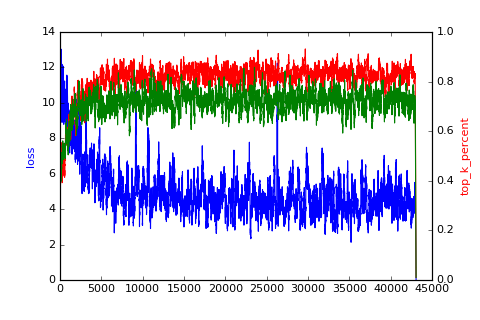

running iteration 310. last iteration took 4.7608301639556885
running iteration 410. last iteration took 5.641763687133789
running iteration 510. last iteration took 5.564659118652344
running iteration 610. last iteration took 5.715811491012573
running iteration 710. last iteration took 5.828801870346069
running iteration 810. last iteration took 5.997165679931641
running iteration 910. last iteration took 5.932687997817993
running iteration 1010. last iteration took 5.874942779541016
running iteration 1110. last iteration took 5.770930290222168
running iteration 1210. last iteration took 5.9674742221832275
running iteration 1310. last iteration took 6.24005651473999
running iteration 1410. last iteration took 5.901457071304321
running iteration 1510. last iteration took 6.300384044647217
running iteration 1610. last iteration took 5.7793073654174805
running iteration 1710. last iteration took 5.624966144561768
running iteration 1810. last iteration took 5.6069722175598145
running iter

KeyboardInterrupt: 

In [18]:
%matplotlib notebook

fig,ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

clk = time.time()


while(True):
    learning_rate = .00008

    input_data, input_rois, input_classes = get_inputs("train")
    
    if i % 100 == 10:
        
        print("running iteration {}. last iteration took {}".format(i, time.time()-clk))
        clk = time.time()
        loss = sess.run(cross_entropy_loss, feed_dict={learning_rate_tf:learning_rate, input_data_tensor:input_data, 
                                    y_:input_classes, rois_in:input_rois})
        
        ax1.cla()
        ax2.cla()
        #ax3.cla()
        ax1.plot(runningMeanFast(np.asarray(stats)[:, 1], 100), "b")
        ax2.plot(runningMeanFast(np.asarray(stats)[:, 0], 100), "r")
        ax2.plot(runningMeanFast(np.asarray(stats)[:, 3], 100), "green")
        #ax3.plot(np.asarray(stats)[:, 2], "black")
        ax1.set_ylabel('loss', color = "b")
        ax2.set_ylabel("top_k_percent", color="r")
        #ax3.set_ylabel("learning_rate", color="black")
        fig.canvas.draw()
    
    elif i % 5 == 0:
        with tf.device("/{}:0".format(device)):
            train_stats = sess.run([top_k_percent, cross_entropy_loss, opt_op], feed_dict={learning_rate_tf:learning_rate, input_data_tensor:input_data, 
                                        y_:input_classes, rois_in:input_rois, num_rois_tf:len(input_rois)})
            
            input_data, input_rois, input_classes = get_inputs("test")
            test_stats = sess.run([top_k_percent], feed_dict={learning_rate_tf:learning_rate, input_data_tensor:input_data, 
                                        y_:input_classes, rois_in:input_rois, num_rois_tf:len(input_rois)})
            
            
            stats.append(train_stats[:-1]+[learning_rate]+test_stats)
    
    else:
        with tf.device("/{}:0".format(device)):
            sess.run(opt_op, feed_dict={learning_rate_tf:learning_rate, input_data_tensor:input_data, 
                                        y_:input_classes, rois_in:input_rois, num_rois_tf:len(input_rois)})

    
    
    i += 1

In [20]:


# Save stats and weights
import pickle
out = sess.run([W_fc6, W_fc7, b_fc6, b_fc7, W_cls, b_cls])

with open("saved_weights_2", "wb") as outfile:
    pickle.dump(out, outfile)

with open("train_stats_2", "wb") as outfile:
    pickle.dump(stats, outfile)

In [21]:
saver = tf.train.Saver()

In [23]:
save_path = saver.save(sess, "model_2.ckpt")